# A2: Enhanced Linear Regression - Car Price Prediction
**Student ID: st126010 - Htut Ko Ko**

This notebook implements enhanced linear regression with polynomial features and Lasso regularization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from LinearRegression import LinearRegression, Ridge, Lasso
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load and clean data
data = pd.read_csv('Cars.csv')
data['mileage'] = data['mileage'].str.extract('(\\d+\\.?\\d*)').astype(float)
data['engine'] = data['engine'].str.extract('(\\d+)').astype(float)
data['max_power'] = data['max_power'].str.extract('(\\d+\\.?\\d*)').astype(float)
data = data.drop(columns=['name', 'torque'])

print(f"Dataset shape: {data.shape}")

Dataset shape: (8128, 11)


In [3]:
# Define features and target
numeric_columns = ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats']
categorical_columns = ['fuel', 'seller_type', 'transmission', 'owner']
feature_names = numeric_columns + categorical_columns

X = data[feature_names].copy()
y = data['selling_price']

print(f"Features: {len(feature_names)}")

Features: 10


In [4]:
# Split data first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

X_train[numeric_columns] = imputer_num.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = imputer_num.transform(X_test[numeric_columns])
X_train[categorical_columns] = imputer_cat.fit_transform(X_train[categorical_columns])
X_test[categorical_columns] = imputer_cat.transform(X_test[categorical_columns])

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print(f"Polynomial features shape: {X_train_poly.shape}")

Polynomial features shape: (6502, 65)


In [5]:
# Test models
models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(learning_rate=0.0001, lambda_reg=0.1, max_iter=2000)
}

results = {}
best_model = None
best_score = -np.inf

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_poly, y_train)
    
    # Evaluate
    if hasattr(model, 'r2'):
        train_r2 = model.r2(X_train_poly, y_train)
    else:
        y_pred_train = model.predict(X_train_poly)
        train_r2 = r2_score(y_train, y_pred_train)
    
    results[name] = {
        'train_r2': train_r2,
        'model': model
    }
    
    if train_r2 > best_score:
        best_score = train_r2
        best_model = (name, model)
    
    print(f"{name}: Train R² = {train_r2:.4f}")

print(f"\nBest model: {best_model[0]} with R² = {best_score:.4f}")

Training Linear...
Linear: Train R² = nan
Training Ridge...
Ridge: Train R² = nan
Training Lasso...
Lasso: Train R² = 0.6993

Best model: Lasso with R² = 0.6993


In [6]:
# Evaluate best model on test set
final_model = best_model[1]

if hasattr(final_model, 'r2'):
    test_r2 = final_model.r2(X_test_poly, y_test)
else:
    y_pred_test = final_model.predict(X_test_poly)
    test_r2 = r2_score(y_test, y_pred_test)

y_pred_test = final_model.predict(X_test_poly)
test_mse = mean_squared_error(y_test, y_pred_test)

print(f"Final Test Results:")
print(f"R² Score: {test_r2:.4f}")
print(f"MSE: {test_mse:.2f}")

# Save model artifacts
model_artifacts = {
    'model': final_model,
    'scaler': scaler,
    'poly': poly,
    'imputer_num': imputer_num,
    'imputer_cat': imputer_cat,
    'label_encoders': label_encoders,
    'feature_names': feature_names,
    'metrics': {
        'test_r2': test_r2,
        'test_mse': test_mse,
        'train_r2': best_score
    },
    'model_type': best_model[0].lower() + '_polynomial'
}

with open('a2_model_artifacts.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("\nModel saved as 'a2_model_artifacts.pkl'")
print(f"🎯 Final Test R²: {test_r2:.4f}")

Final Test Results:
R² Score: 0.7015
MSE: 195680425945.36

Model saved as 'a2_model_artifacts.pkl'
🎯 Final Test R²: 0.7015


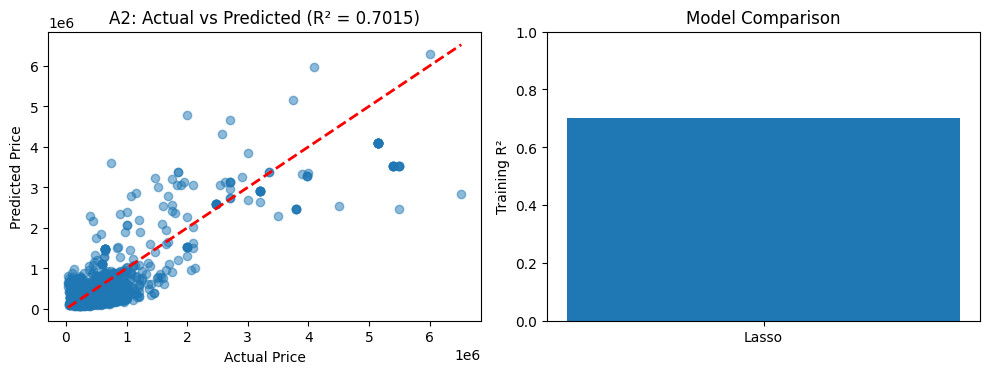


A2 Enhanced Linear Regression completed!


In [7]:
# Visualize results
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'A2: Actual vs Predicted (R² = {test_r2:.4f})')

plt.subplot(1, 2, 2)
model_names = list(results.keys())
train_scores = [results[name]['train_r2'] for name in model_names]

plt.bar(model_names, train_scores)
plt.ylabel('Training R²')
plt.title('Model Comparison')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

print("\nA2 Enhanced Linear Regression completed!")